In [1]:
%pylab inline
import sys

import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import arviz as az

import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.font_manager as fm

rcParams['font.family'] = 'sans-serif'

sys.path.append('../')
from mederrata_spmf import PoissonMatrixFactorization


Populating the interactive namespace from numpy and matplotlib


# Generate a count matrix of random noise

We want our factor model to tell us that this is just noise

In [2]:
N = 50000
D = 20
P = 3

# Test taking in from tf.dataset, don't pre-batch
data = tf.data.Dataset.from_tensor_slices(
    {
        'data': np.random.poisson(3.0, size=(N, D)),
        'indices': np.arange(N),
        'normalization': np.ones(N)
    })

data = data.batch(1000)


Currently, the input data has to be in this format, as a tensorflow BatchDataset object with the given key/values.

# Set up the inference object

In [3]:
# strategy = tf.distribute.MirroredStrategy()
strategy = None
factor = PoissonMatrixFactorization(
    data, latent_dim=P, strategy=strategy,
    encoder_function=lambda x: x, decoder_function=lambda x: x,
    dtype=tf.float64, u_tau_scale=1.)
# Test to make sure sampling works


Feature dim: 20 -> Latent dim 3


## Test out the prior distributions

In [4]:
## 
sample = factor.joint_prior.sample(10)
# Compute the joint log probability of the sample
probs = factor.joint_prior.log_prob(sample)
sample_surrogate = factor.surrogate_distribution.sample(77)
probs_parts = factor.unormalized_log_prob_parts(
    **sample_surrogate, data=next(iter(data)))
prob = factor.unormalized_log_prob(
    **sample_surrogate,  data=next(iter(data)))



# Inference

In [5]:
losses = factor.calibrate_advi(
    num_epochs=50, rel_tol=1e-4, learning_rate=.1)



W0520 13:56:21.812844 4675866048 deprecation.py:506] From /usr/local/lib/python3.7/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Initial loss: 71.17211964838827
Epoch 1: average-batch loss: 40.273791966905144 last batch loss: 36.396477676317225
Saved a checkpoint: ./.tf_ckpts/chkpt-1
Epoch 2: average-batch loss: 36.24221051445322 last batch loss: 36.05490900892242
Saved a checkpoint: ./.tf_ckpts/chkpt-2
Epoch 3: average-batch loss: 36.06379352053034 last batch loss: 35.98621787488227
Saved a checkpoint: ./.tf_ckpts/chkpt-3
Epoch 4: average-batch loss: 36.02740212311611 last batch loss: 35.95568874321569
Saved a checkpoint: ./.tf_ckpts/chkpt-4
Epoch 5: average-batch loss: 36.01092973342313 last batch loss: 35.94047791862466
Saved a checkpoint: ./.tf_ckpts/chkpt-5
Epoch 6: average-batch loss: 36.00133512549653 last batch loss: 35.95510105553898
Saved a checkpoint: ./.tf_ckpts/chkpt-6
Epoch 7: average-batch loss: 35.99527207134821 last batch loss: 35.916981954645934
Saved a checkpoint: ./.tf_ckpts/chkpt-7
Epoch 8: average-batch loss: 35.993658846331044 last batch loss: 35.92454240781613
Saved a checkpoint: ./.tf_ck

# Compute the WAIC

In [6]:
waic = factor.waic()
print(waic)

{'waic': 346327.47237696, 'se': 1471.5019416768293, 'lppd': -38190.8546267497, 'pwaic': 134972.8815617303}


# Plot the factor encoding matrix

In [7]:
intercept_data = az.convert_to_inference_data(
    {
        r"$s_dw_d$": tf.squeeze(
            factor.surrogate_distribution.sample(1000)['w']*factor.norm_factor).numpy().T})

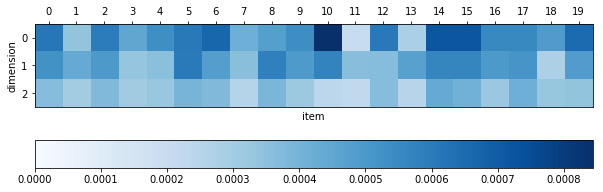

In [8]:
fig, ax = plt.subplots(figsize=(10,4))

plt.imshow(factor.encoding_matrix().numpy().T, vmin=0, cmap="Blues")
plt.xticks(np.arange(D))
ax.set_xlabel("item")
ax.set_ylabel("dimension")
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = True, labeltop=True)
plt.yticks(np.arange(P))
plt.colorbar(orientation = "horizontal")
plt.show()


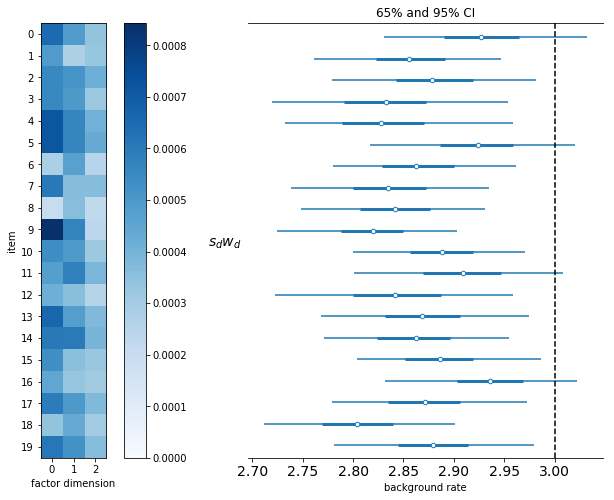

In [9]:
fig, ax = plt.subplots(1,2, figsize=(14,8))

pcm = ax[0].imshow(factor.encoding_matrix().numpy()[::-1,:], vmin=0, cmap="Blues")
ax[0].set_yticks(np.arange(D))
ax[0].set_yticklabels(np.arange(D))
ax[0].set_ylabel("item")
ax[0].set_xlabel("factor dimension")
ax[0].set_xticks(np.arange(P))
ax[0].set_xticklabels(np.arange(P))

fig.colorbar(pcm, ax=ax[0], orientation = "vertical")
az.plot_forest(intercept_data, ax=ax[1])
ax[1].set_xlabel("background rate")
ax[1].set_ylim((-0.014,.466))
ax[1].set_title("65% and 95% CI")
ax[1].axvline(3.0, linestyle='dashed', color="black")
plt.savefig('noise_factorization_sepmf.pdf', bbox_inches='tight')
plt.show()


The values in the factor encoding matrix as near zero. There is a gradient because the model induces a dimensional decay to remove symmetries - this encourages the leading dimensions to hold more of the signal.

In [10]:
factor.calibrated_expectations['s']/tf.reduce_sum(factor.calibrated_expectations['s'], axis=0, keepdims=True)

<tf.Tensor: shape=(2, 20), dtype=float64, numpy=
array([[0.00204613, 0.00161471, 0.00240402, 0.00163486, 0.0017149 ,
        0.00212046, 0.00225436, 0.00175337, 0.00204892, 0.00194632,
        0.00196195, 0.00149287, 0.00210638, 0.00161517, 0.00208458,
        0.00220554, 0.00199841, 0.00236167, 0.00165148, 0.00214342],
       [0.99795387, 0.99838529, 0.99759598, 0.99836514, 0.9982851 ,
        0.99787954, 0.99774564, 0.99824663, 0.99795108, 0.99805368,
        0.99803805, 0.99850713, 0.99789362, 0.99838483, 0.99791542,
        0.99779446, 0.99800159, 0.99763833, 0.99834852, 0.99785658]])>

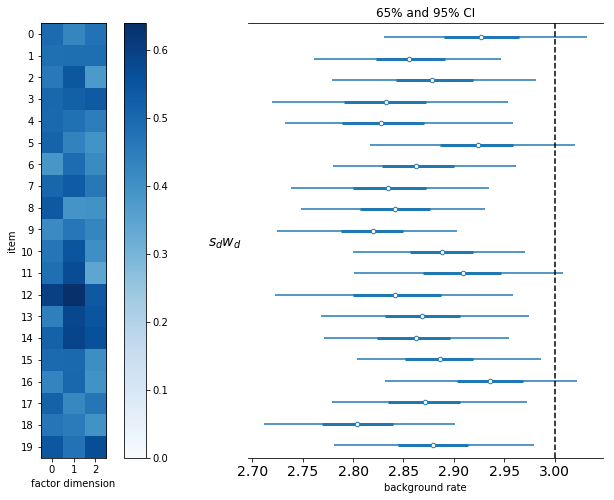

In [11]:
fig, ax = plt.subplots(1,2, figsize=(14,8))

pcm = ax[0].imshow(factor.decoding_matrix().numpy().T[::-1,:], vmin=0, cmap="Blues")
ax[0].set_yticks(np.arange(D))
ax[0].set_yticklabels(np.arange(D))
ax[0].set_ylabel("item")
ax[0].set_xlabel("factor dimension")
ax[0].set_xticks(np.arange(P))
ax[0].set_xticklabels(np.arange(P))

fig.colorbar(pcm, ax=ax[0], orientation = "vertical")
az.plot_forest(intercept_data, ax=ax[1])
ax[1].set_xlabel("background rate")
ax[1].set_ylim((-0.014,.466))
ax[1].set_title("65% and 95% CI")
ax[1].axvline(3.0, linestyle='dashed', color="black")
plt.show()
